In [78]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as sps
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Загрузим данные и посмотрим на них:

In [79]:
data = pd.read_csv('/content/grocerywebsiteabtestdata.csv')

In [80]:
print(data.shape)
data.head()

(184588, 5)


,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


Видим, что данные состоят из 5 столбцов:


1.   RecordID $-$ идентификатор записи
2.   IP adress $-$ ip-адрес
3.   LoggedInFlag $-$ вошёл ли пользователь в свой аккаунт
4.   Server ID $-$ сервер, через который был направлен пользователь
5.   VisitPageFlag $-$ наша целевая переменная, которая отвечает за то, кликнул ли пользователь на страницу программы лояльности (loyalty program page)

Проверим данные на "чистоту":

In [81]:
data.isna().sum(axis=0)

RecordID         0
IP Address       0
LoggedInFlag     0
ServerID         0
VisitPageFlag    0
dtype: int64

Nan'ов нет - очень хорошо.

Теперь посмотрим на уникальные значения по столбцам и их количество:

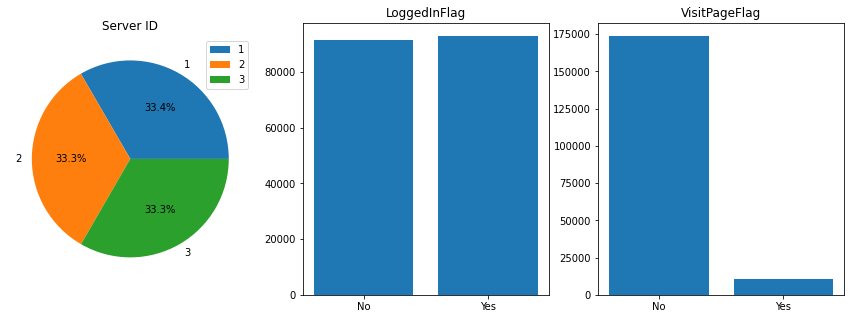

In [82]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
x = data['ServerID'].value_counts().sort_index()
plt.pie(x=x, labels=x.index, autopct='%1.1f%%')
plt.title("Server ID")
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(x=['No', 'Yes'], height=data['LoggedInFlag'].value_counts().sort_index())
plt.title("LoggedInFlag")

plt.subplot(1, 3, 3)
plt.bar(x=['No', 'Yes'], height=data['VisitPageFlag'].value_counts().sort_index())
plt.title("VisitPageFlag")

plt.show()

In [83]:
data['IP Address'].value_counts()

224.4.217.7     9
26.4.102.8      8
5.7.136.5       8
105.14.173.2    8
52.3.153.6      8
               ..
197.6.50.6      1
192.3.21.1      1
3.13.120.6      1
101.10.180.3    1
207.2.110.5     1
Name: IP Address, Length: 99516, dtype: int64

Видим, что записи распределены по серверам и по параметру LoggedInFlag равномерно, а конверсия в посещение страницы составляет примерно 7-10%. 

Также стоит учесть то, что есть ip-адреса, с которых страницу посещали несколько раз, при этом уникальных значений ip-адреса в два раза меньше, чем всего записей в таблице. Заведём стоблец Total_VisitPageFlag, в котором будем хранить количество посещений страницы лояльности для одинаковых записей (записи считаются одинаковыми, если у них совпадает не только ip-адрес, но  и ServerID с LoggedInFlag):

In [84]:
data = data.groupby(['IP Address', 'LoggedInFlag', 'ServerID'])['VisitPageFlag'].sum().reset_index(name='Total_VisitPageFlag')
data.Total_VisitPageFlag.value_counts()

0    89785
1     9238
2      719
3       20
4        1
Name: Total_VisitPageFlag, dtype: int64

Так как нам важен сам факт посещения, то сделаем следующее: каждой записи с Total_VisitPageFlag $\geq 1$ присвоим 1, иначе 0:

In [85]:
data['Total_VisitPageFlag'] = data['Total_VisitPageFlag'].apply(lambda x: 1 if x > 0 else 0)
data.Total_VisitPageFlag.value_counts()

0    89785
1     9978
Name: Total_VisitPageFlag, dtype: int64

Я собирался провести два A/B-теста для того, чтобы исследовать:

1.   влияние залогиненности пользователя (столбец LoggedInFlag) на CTR ссылки программы лояльности
2.   влияние сервера (стобец ServerID) на тот же CTR

Однако при составлении таблицы сопряжённости для критерия хи-квадрат Пирсона я обнаружил, что залогиненные пользователи совсем не посещают страницу программы лояльности (ячейка кода ниже). Следовательно, хи-квадрат применять нельзя (при таком раскладе это и так не имеет особого смысла). Возможно, подобный казус с нулевой посещаемостью залогиненных пользователей вызван ошибкой с технической стороны - например, фронтэндеры сделали ссылку некликабельной :)

In [86]:
cont_table = pd.crosstab(data['LoggedInFlag'],
                         data['Total_VisitPageFlag'])
cont_table

Total_VisitPageFlag,0,1
LoggedInFlag,,
0,39535,9978
1,50250,0


Поэтому ограничимся вторым A/B-тестом: будем сравнивать CTR на различных серверах. Разобьём на группы:

In [87]:
data_1 = data[data['ServerID']==1]
data_2 = data[data['ServerID']==2]
data_3 = data[data['ServerID']==3]

print(f"CTR for server 1: {round(data_1.Total_VisitPageFlag.sum()/data_1.shape[0], 4)}")
print(f"CTR for server 2: {round(data_2.Total_VisitPageFlag.sum()/data_1.shape[0], 4)}")
print(f"CTR for server 3: {round(data_3.Total_VisitPageFlag.sum()/data_1.shape[0], 4)}")

CTR for server 1: 0.1155
CTR for server 2: 0.0916
CTR for server 3: 0.0925


CTR серверов 2 и 3 отличаются лишь в третьем знаке после запятой. Думаю, имеет смысл объединить в контрольную группу сервера 2 и 3, а в тестовую определить сервер 1, чтобы не пришлось замарачиваться с поправками на множественную проверку гипотез.

Посмотрим также на распределение залогиненных пользователей по серверам:

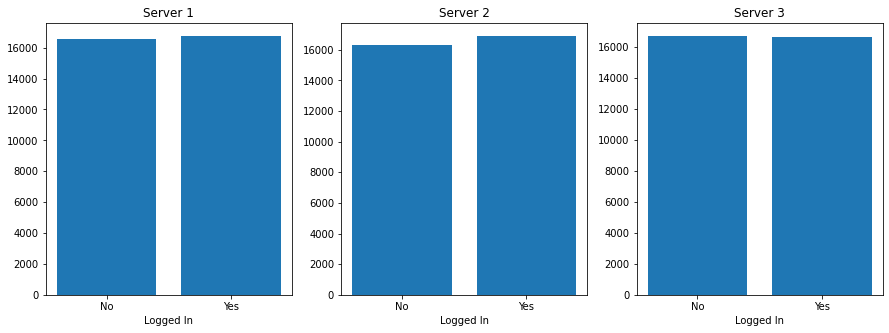

In [88]:
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.bar(x=['No', 'Yes'], height=data[data['ServerID']==i+1].LoggedInFlag.value_counts().sort_index())
    plt.title(f"Server {i+1}")
    plt.xlabel('Logged In')

plt.show()

Видим, что всё однородно $-$ можно спокойно применять стат. критерии.

Применим **критерий хи-квадрат Пирсона**. Формально поставим задачу:

Гипотеза $H_0$: $CTR(Server \; 1) = CTR(Server \; 2 \; \& \; 3) \; -$ сервер не влияет на посещаемость страницы программы лояльности;

Гипотеза $H_1$: $CTR(Server \; 1) \neq CTR(Server \; 2 \; \& \; 3) \; -$ есть статистически значимое различие в CTR между серверами.

Обозначим уровень значимости:  $\alpha = 0.01$

Создадим колонку Group, в которой, как и обговаривалось выше, серверу 1 присвоим значение test, а серверам 2 и 3 - control. Посмотрим, что получилось:

In [89]:
data['Group'] = data['ServerID'].map({1: 'test',
                          2: 'control',
                          3: 'control'})
data.head()

,IP Address,LoggedInFlag,ServerID,Total_VisitPageFlag,Group
0,0.0.108.2,0,1,0,test
1,0.0.109.6,1,1,0,test
2,0.0.111.8,0,3,0,control
3,0.0.160.9,1,2,0,control
4,0.0.163.1,0,2,0,control


Создадим таблицу сопряжённости:

In [90]:
new_cont_table = pd.crosstab(data['Group'],
                         data['Total_VisitPageFlag'])
new_cont_table

Total_VisitPageFlag,0,1
Group,,
control,60329,6131
test,29456,3847


Мы готовы применять критерий:

In [91]:
p_value = sps.chi2_contingency(new_cont_table)[1]

print(f"p-value = {p_value}")

p-value = 8.439189241264638e-31


In [92]:
# посчитаем ctr на тесте и контроле:
data_test = data[data['Group']=='test']
data_control = data[data['Group']=='control']
test_ctr = data_test.Total_VisitPageFlag.sum()/data_test.shape[0]
control_ctr = data_control.Total_VisitPageFlag.sum()/data_control.shape[0]

print(f"Test CTR: {round(test_ctr, 4)}")
print(f"Control CTR: {round(control_ctr, 4)}")
print(f"Difference: {round(test_ctr - control_ctr, 4)}")

Test CTR: 0.1155
Control CTR: 0.0923
Difference: 0.0233


**Вывод:**

Критерий выдал p-value сильно меньше определённого ранее уровня значимости $-$ значит, гипотезу $H_0$ мы смело отвергаем и говорим, что есть статистически значимое "превосходство" сервера 1 над остальными (примерно на 2.3 процентных пункта). Было бы интересно также посмотреть на влияние залогиненности на CTR, однако, как отмечалось выше, отсутствие активности залогиненнных пользователей не даёт провести подобный анализ.